In [1]:
#импорт библиотек
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString
from unifloc import FluidFlow, Pipeline, AmbientTemperatureDistribution, Trajectory
from unifloc.well.gaslift_well import GasLiftWell
import unifloc.tools.units_converter as uc

In [2]:
import warnings
warnings.filterwarnings("ignore")

sns.set()

In [3]:
# считывание файлов .json
name_1 = '7-1.json'
name_2 = '7-2.json'

with open(name_1) as f1:
    data1 = json.load(f1)
    
with open(name_2) as f2:
    data2 = json.load(f2)

In [4]:
data1

{'fluid': {'gamma_oil': 0.8384426106276751,
  'gamma_water': 1.0082592103842374,
  'gamma_gas': 0.6213795425564086,
  'wct': 0.10149678045147584,
  'rp': 128.00570246868205},
 'pipe': {'tubing': {'d': 0.08847085135529541,
   'md': 1400,
   'roughness': 0.0007512771285180254},
  'casing': {'d': 0.10954373105480357, 'roughness': 0.0003866576833414187}},
 'inclinometry': {'md': [0,
   1400,
   1837.8639441471669,
   1897.860642148579,
   1979.628758377787,
   2031.4027243448386,
   2074.1061018522855,
   2087.2478435157595],
  'tvd': [0,
   1300,
   1611.4106960044446,
   1627.2894824618293,
   1641.8476868779542,
   1676.0728568635625,
   1711.822315836336,
   1716.2006850259984]},
 'temperature': {'t_res': 70.37059783303857, 'temp_grad': 2.3001121159232483},
 'reservoir': {'md_vdp': 2087.2478435157595,
  'p_res': 202.08143444253244,
  'pi': 1.3065199831356165},
 'regime': {'p_wh': 25.20931436784529}}

In [5]:
class Calc_Well:
    """
    Класс для моделирования фонтанных и газлифтных скважин.
    """

    number = 100 # Число элементов в массиве p_wf_list

    def __init__(self, data1, data2):

        self.number = 100 # Число элементов в массиве p_wf_list

        # Задание 1
        self.p_res = data1['reservoir']['p_res']
        self.pi = data1['reservoir']['pi']
        self.md_vdp = data1['reservoir']['md_vdp']
        self.p_wf_list = np.linspace(0, self.p_res, self.number)
        self.q_liq_list = self.calc_q_list()

        self.wct = data1["fluid"]["wct"]
        self.init_well(data1)
        self.p_wh = data1["regime"]["p_wh"]
        self.find_min_pwh()

        # Решение 1-го пункта задачи
        self.min_p_wf = self.calc_p_wf(self.min_q_liq, self.min_p_wh) # Ответ на задачу 1

        # Построение IPR и линии минимального необходимого дебита скважины
        self.ax_ipr.plot(self.p_wf_list, self.q_liq_list)
        self.ax_ipr.plot(self.p_wf_list, [self.min_q_liq] * len(self.q_liq_list))
        self.ax_ipr.set(xlabel='Забойное давление, атм', ylabel='Дебит жидкости, м3/сут')

        # Задание 2
        self.md_valve = data2['md_valve']
        self.init_gl_well(data1)
        self.q_inj_opt, self.q_liq_opt = self.find_max_gl_solution()

    def calc_ipr(self, p_res, p_wf, pi):
        """
        Расчет IPR.
        """
        return pi * (p_res - p_wf)

    def calc_q_list(self):
        """
        Расчет массива значений дебита по IPR, при известных pi, p_res, p_wf.
        """
        return [self.calc_ipr(self.p_res, p_wf, self.pi) for p_wf in self.p_wf_list]

    def calc_amb_temp(self, t_res, tvd_vdp, grad_t, tvd_h):
        """
        Расчет температура по глубине.
        """
        return t_res - grad_t * (tvd_vdp - tvd_h) / 100 + 273.15

    def init_well(self, data1):
        """
        Инициализация скважины.
        """
        fluid =  FluidFlow(
            q_fluid=100/86400, 
            wct=self.wct,
            pvt_model_data={
               "black_oil": 
                           {"gamma_gas": data1["fluid"]["gamma_gas"], 
                            "gamma_wat": data1["fluid"]["gamma_water"], 
                            "gamma_oil": data1["fluid"]["gamma_oil"],
                            "rp": data1["fluid"]["rp"]
                            }
            }
        )
        self.inclinometry = {"MD": data1["inclinometry"]["md"],
                       "TVD": data1["inclinometry"]["tvd"]}
        traj = Trajectory(inclinometry=self.inclinometry)


        T_list = []
        t_res = data1["temperature"]["t_res"]
        tvd_vdp = data1["inclinometry"]["tvd"][-1]
        grad_t = data1["temperature"]["temp_grad"]

        for depth in data1["inclinometry"]["tvd"]:
            T_list.append(self.calc_amb_temp(t_res, tvd_vdp, grad_t, depth))

        self.amb_dist = {"MD": data1["inclinometry"]["md"],
                    "T": T_list}
        amb = AmbientTemperatureDistribution(ambient_temperature_distribution = self.amb_dist)

        self.casing = Pipeline(
            top_depth = data1["pipe"]["tubing"]["md"],
            bottom_depth = data1["reservoir"]["md_vdp"],
            d = data1["pipe"]["casing"]["d"],
            roughness = data1["pipe"]["casing"]["roughness"],
            fluid = fluid,
            trajectory = traj,
            ambient_temperature_distribution = amb
        )
        self.tubing = Pipeline(
            top_depth = 0,
            bottom_depth = data1["pipe"]["tubing"]["md"],
            d = data1["pipe"]["tubing"]["d"],
            roughness = data1["pipe"]["tubing"]["roughness"],
            fluid = fluid,
            trajectory = traj,
            ambient_temperature_distribution = amb
        )

    def find_min_pwh(self):
        """
        Нахождение минимального забойного давления фонтанирующей скважины.
        """
        pt_wh = np.zeros(len(self.p_wf_list))

        for i in range(len(self.p_wf_list)):
            pt = self.casing.calc_pt(
                h_start='bottom',
                p_mes = self.p_wf_list[i] * 101325,
                flow_direction=-1,
                q_liq=self.q_liq_list[i]/86400,
                extra_output=True
                  )
            pt_wh[i] = self.tubing.calc_pt(
                h_start='bottom',
                p_mes = pt[0],
                flow_direction = -1,
                q_liq=self.q_liq_list[i] / 86400,
                extra_output = True
            )[0]

        fig, (self.ax_vlp, self.ax_ipr, self.ax_gl) = plt.subplots(1, 3, figsize=(16,8))
        self.ax_vlp.set_title('VLP')
        self.ax_ipr.set_title('IPR')
        self.ax_gl.set_title('Регулировочная кривая газлифтного подъемника')

        # Отрисовка VLP и линии минимального допустимого устьевого давления
        self.ax_vlp.plot(self.q_liq_list, 
            [self.p_wh for q_liq in range(len(self.q_liq_list))])
        self.ax_vlp.plot(self.q_liq_list,
            np.array(pt_wh) / 101325)
        self.ax_vlp.set(xlabel = 'Дебит жидкости, м3/сут', ylabel = 'Устьевое давление, атм')

        #  Нахождение минимального забойного давления фонтанирующей скважины
        self.min_q_liq, self.min_p_wh = self.find_sol(
            self.q_liq_list, 
            [self.p_wh for q_liq in range(len(self.q_liq_list))], 
            self.q_liq_list,
            np.array(pt_wh) / 101325
        )

    def calc_p_wf(self, min_q, min_p_wh):
        pt = self.casing.calc_pt(
            h_start='top',
            p_mes = min_p_wh * 101325,
            flow_direction=1,
            q_liq=min_q/86400,
            extra_output=True
              )
        return self.tubing.calc_pt(
            h_start='top',
            p_mes = pt[0],
            flow_direction=1,
            q_liq=min_q/86400,
            extra_output=True
        )[0]/101325

    def find_sol(self, f_x: list, f_y: list, s_x: list, s_y: list):
        """
        Функция поиска точки пересечения
        """
        first_line = LineString(np.column_stack((f_x, f_y)))
        second_line = LineString(np.column_stack((s_x, s_y)))
        try:
            intersection = first_line.intersection(second_line)
        except:
            first_line = first_line.buffer(0)
            intersection = first_line.intersection(second_line)
        if intersection.type == "MultiPoint":
            results = [(p.x, p.y) for p in intersection]
            return results[-1]
        try:
            x, y = intersection.xy
            return x[0], y[0]
        except (NotImplementedError, AttributeError) as e:
            return None, None

    def init_gl_well(self, data1):
        """
        Функция инициализирующая газлифтную скважину.
        """
        pipe_data = {
            'casing': {'bottom_depth': data1["reservoir"]["md_vdp"], 'd': data1["pipe"]["casing"]["d"],
                      'roughness': data1["pipe"]["casing"]["roughness"]
                      },
            'tubing': {'bottom_depth': data1["pipe"]["tubing"]["md"], 'd': data1["pipe"]["tubing"]["d"],
                      'roughness': data1["pipe"]["tubing"]["roughness"]
                      }
        }
        well_trajectory_data = {'inclinometry': self.inclinometry}
        fluid_data = {
            'q_fluid': 100 / 86400, 
            'wct': self.wct,
            'pvt_model_data': {
                'black_oil': {
                    "gamma_gas": data1["fluid"]["gamma_gas"], 
                        "gamma_wat": data1["fluid"]["gamma_water"], 
                        "gamma_oil": data1["fluid"]["gamma_oil"],
                        "rp": data1["fluid"]["rp"]              
                }
            }

        }
        equipment_data = {
            "gl_system": {
                "valve1": {
                    "h_mes": self.md_valve,
                    "d": 0.006
                }
            }
        }
        self.well = GasLiftWell(
            fluid_data, 
            pipe_data, 
            well_trajectory_data,
            self.amb_dist, 
            equipment_data
        )

    def calc_gl_p_wf(self, q_liq, q_gas_inj):
        return self.well.calc_pwf_pfl(
            self.p_wh * 101325, uc.convert_rate(q_liq, "m3/day", "m3/s"), 
            self.wct,
            q_gas_inj = uc.convert_rate(q_gas_inj, "m3/day", "m3/s")
) / 101325

    def calc_gl_vlp(self, q_gas_inj):
        return [self.calc_gl_p_wf(q_liq, q_gas_inj) for q_liq in self.q_liq_list]

    def calc_gl_curve(self):
        self.q_gas_inj_list = [q_gas for q_gas in range(5000, 150000, 10000)]
        self.gl_curve = []
        for q_gas_inj in self.q_gas_inj_list:
            self.gl_curve.append(
                self.find_sol(
                    self.q_liq_list,
                    self.p_wf_list,
                    self.q_liq_list,
                    self.calc_gl_vlp(q_gas_inj)       
                )[0]
            )

    def find_max_gl_solution(self):
        """
        Функция для определения оптимального расхода газлифтного газа.
        """
        self.calc_gl_curve()

        # Построение регулировочной кривой газлифтного подъемника
        self.ax_gl.plot(self.q_gas_inj_list, self.gl_curve)
        self.ax_gl.plot(self.q_gas_inj_list[self.gl_curve.index(max(self.gl_curve))], max(self.gl_curve), "ro")
        self.ax_gl.set(xlabel='Расход газлифтного газа, м3/сут', ylabel='Дебит жидкости, м3/сут')

        return self.q_gas_inj_list[self.gl_curve.index(max(self.gl_curve))], max(self.gl_curve)

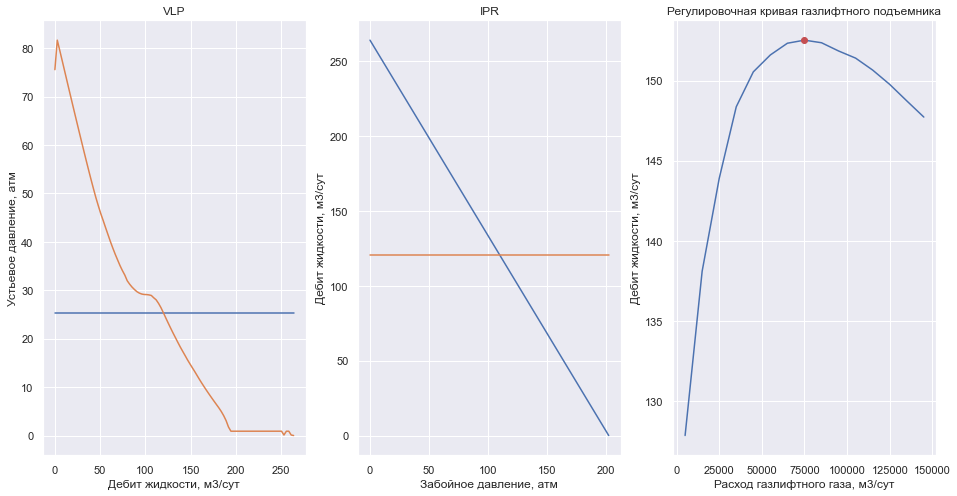

In [6]:
well_calc = Calc_Well(data1, data2)

In [7]:
# запись результатов в файл
dict_to_json = {   
                "t1": {
                    "pwf": well_calc.min_p_wf
                },
                "t2": {
                "q_inj": well_calc.q_inj_opt,
                "q_liq": well_calc.q_liq_opt
                }
            }

filename = 'output_2.json'

with open(filename, 'w') as f:
    json.dump(dict_to_json, f)